In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## 0. Load Data

In [3]:
data = pd.read_csv('../data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [4]:
data["SIGLAORI"].unique()
# We are working on flights that landing off from Santiago, not taking of ass the problem description.

array(['Santiago'], dtype=object)

## 1. Data Analysis: First Sight

### How is the date distribuited?

In [5]:
def plot_flights_by_feature(x: pd.DataFrame, y: pd.DataFrame, feat_name: str, ylabel: str, size=(10, 2)) -> None:
    plt.figure(figsize = size)
    sns.set(style="darkgrid")
    sns.barplot(x=x, y=y, color = 'lightblue', alpha=0.9)
    plt.title(f'{ylabel} by {feat_name}')
    plt.ylabel(f'{ylabel}', fontsize=12)
    plt.xlabel(f'{feat_name}', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

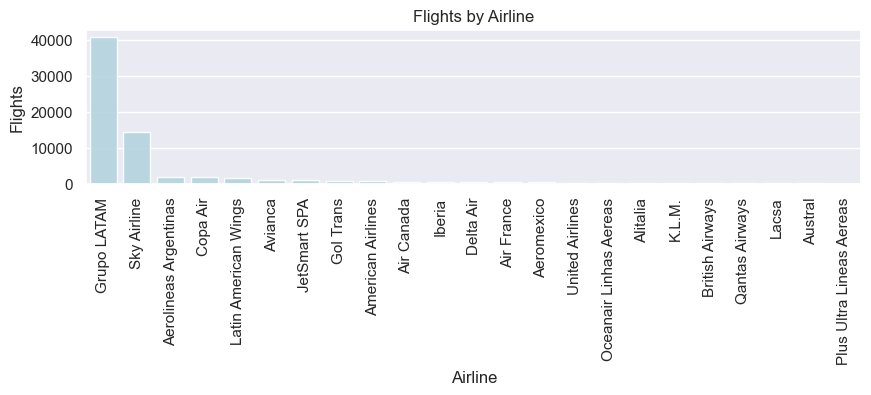

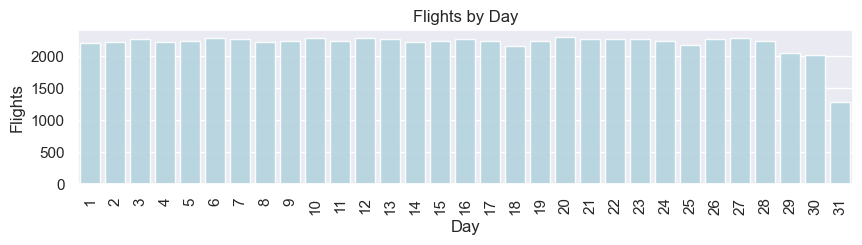

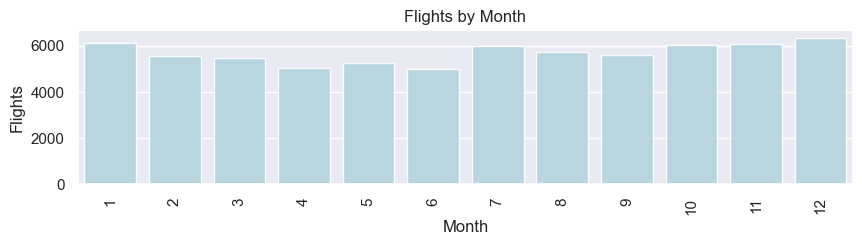

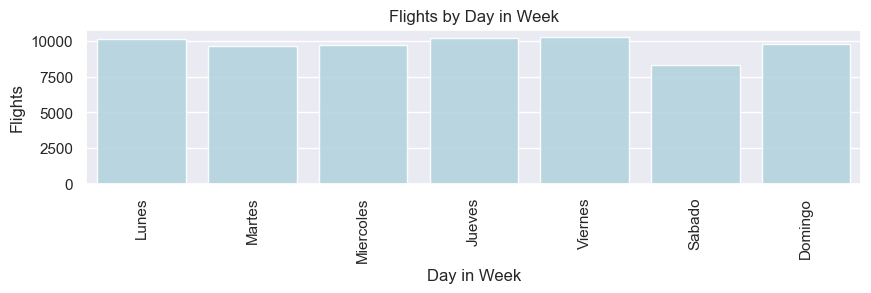

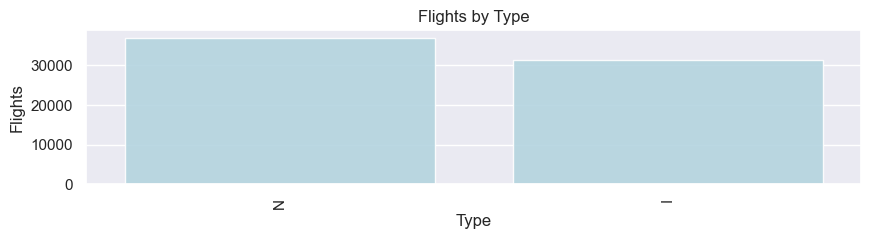

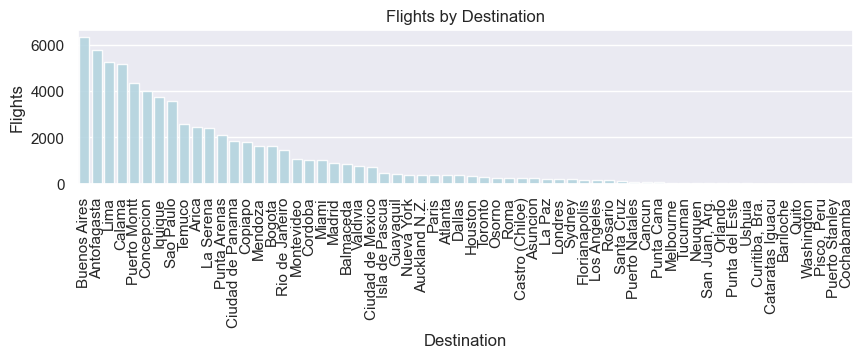

In [6]:
feat_name_map = {
    "OPERA": "Airline",
    "DIA": "Day",
    "MES": "Month",
    "DIANOM": "Day in Week",
    "TIPOVUELO": "Type",
    "SIGLADES": "Destination"
}

for feat, name in feat_name_map.items():
    flights_by_feat = data[feat].value_counts()
    idx_by_feat  = flights_by_feat.index
    values_by_feat = flights_by_feat.values
    if feat == "DIANOM":
        order = [2, 5, 4, 1, 0, 6, 3]
        idx_by_feat = [idx_by_feat[idx] for idx in order]
        values_by_feat = [values_by_feat[idx] for idx in order]

    plot_flights_by_feature(x=idx_by_feat, y=values_by_feat, feat_name=name, ylabel="Flights")

## 2. Features Generation

### 2.a. Period of Day

In [7]:
from datetime import datetime

def get_period_day(date):
    date_time = datetime.strptime(date, '%Y-%m-%d %H:%M:%S').time()
    morning_min = datetime.strptime("05:00", '%H:%M').time()
    morning_max = datetime.strptime("11:59", '%H:%M').time()
    afternoon_min = datetime.strptime("12:00", '%H:%M').time()
    afternoon_max = datetime.strptime("18:59", '%H:%M').time()
    evening_min = datetime.strptime("19:00", '%H:%M').time()
    evening_max = datetime.strptime("23:59", '%H:%M').time()
    night_min = datetime.strptime("00:00", '%H:%M').time()
    night_max = datetime.strptime("4:59", '%H:%M').time()
    
    if(date_time > morning_min and date_time < morning_max):
        return 'mañana'
    elif(date_time > afternoon_min and date_time < afternoon_max):
        return 'tarde'
    elif(
        (date_time > evening_min and date_time < evening_max) or
        (date_time > night_min and date_time < night_max)
    ):
        return 'noche'

In [8]:
data['period_day'] = data['Fecha-I'].apply(get_period_day)

### 2.b. High Season

In [9]:
from datetime import datetime

def is_high_season(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0

In [10]:
data['high_season'] = data['Fecha-I'].apply(is_high_season)

### 2.c. Difference in Minutes

In [11]:
def get_min_diff(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    min_diff = ((fecha_o - fecha_i).total_seconds())/60
    return min_diff

In [12]:
data['min_diff'] = data.apply(get_min_diff, axis = 1)

### 2.d. Delay

In [13]:
threshold_in_minutes = 15
data['delay'] = np.where(data['min_diff'] > threshold_in_minutes, 1, 0)

In [14]:
data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day', 'high_season',
       'min_diff', 'delay'],
      dtype='object')

## 3. Data Analysis: Second Sight

### How is the delay rate across columns?

In [16]:
def get_rate_from_column(data, column):
    delays = {}
    for _, row in data.iterrows():
        if row['delay'] == 1:
            if row[column] not in delays:
                delays[row[column]] = 1
            else:
                delays[row[column]] += 1
    total = data[column].value_counts().to_dict()
    
    rates = {}
    for name, total in total.items():
        if name in delays:
            rates[name] = round(total / delays[name], 2)
        else:
            rates[name] = 0
            
    return pd.DataFrame.from_dict(data = rates, orient = 'index', columns = ['Tasa (%)'])

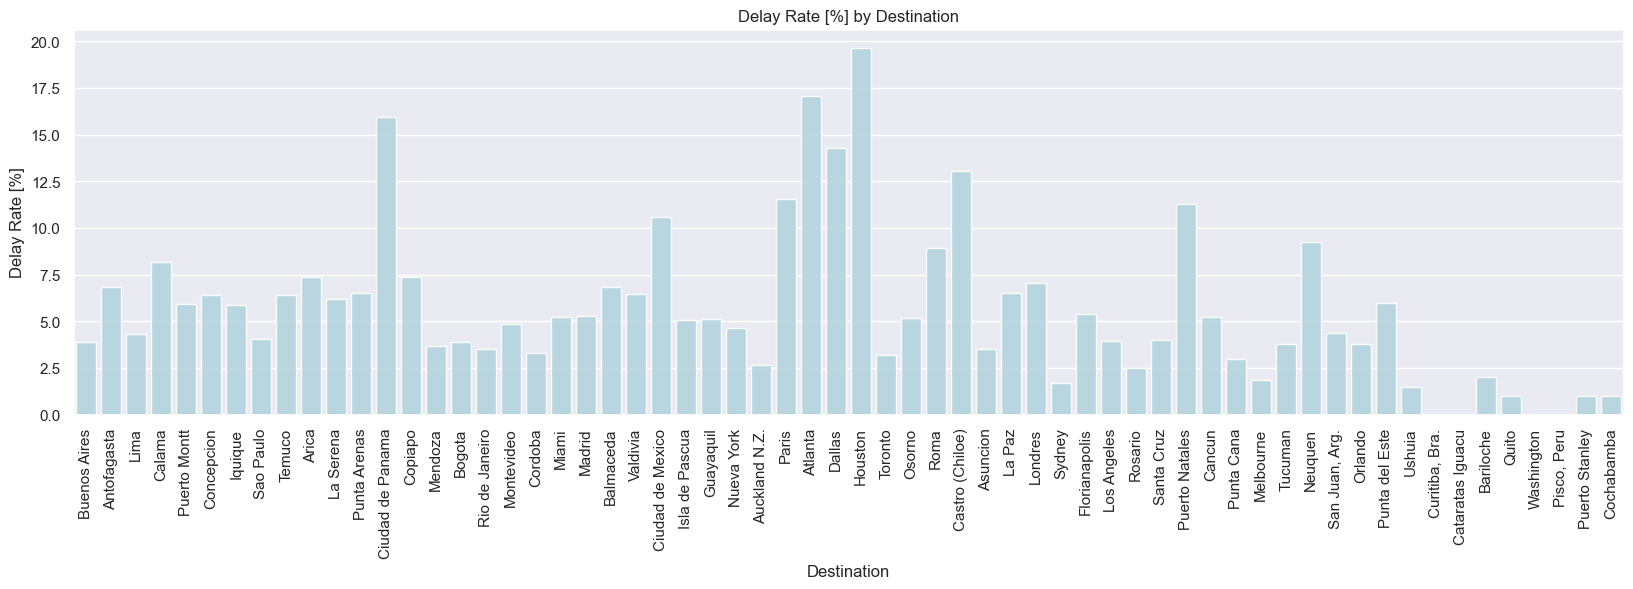

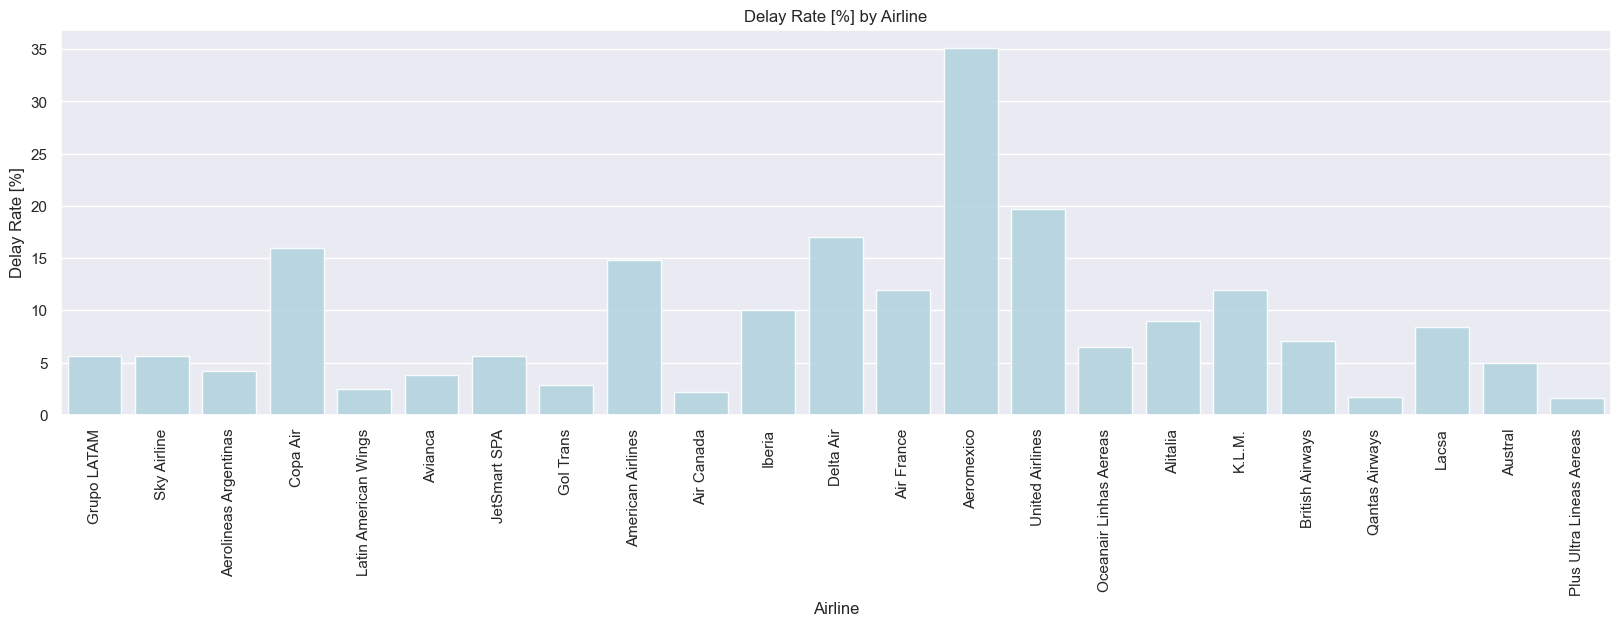

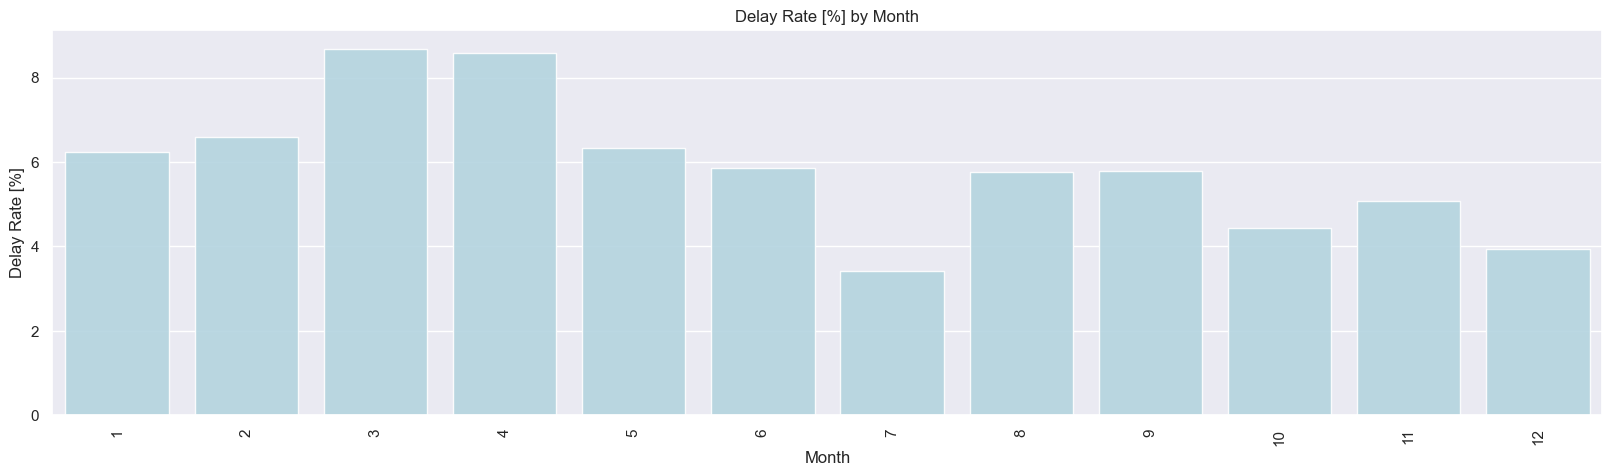

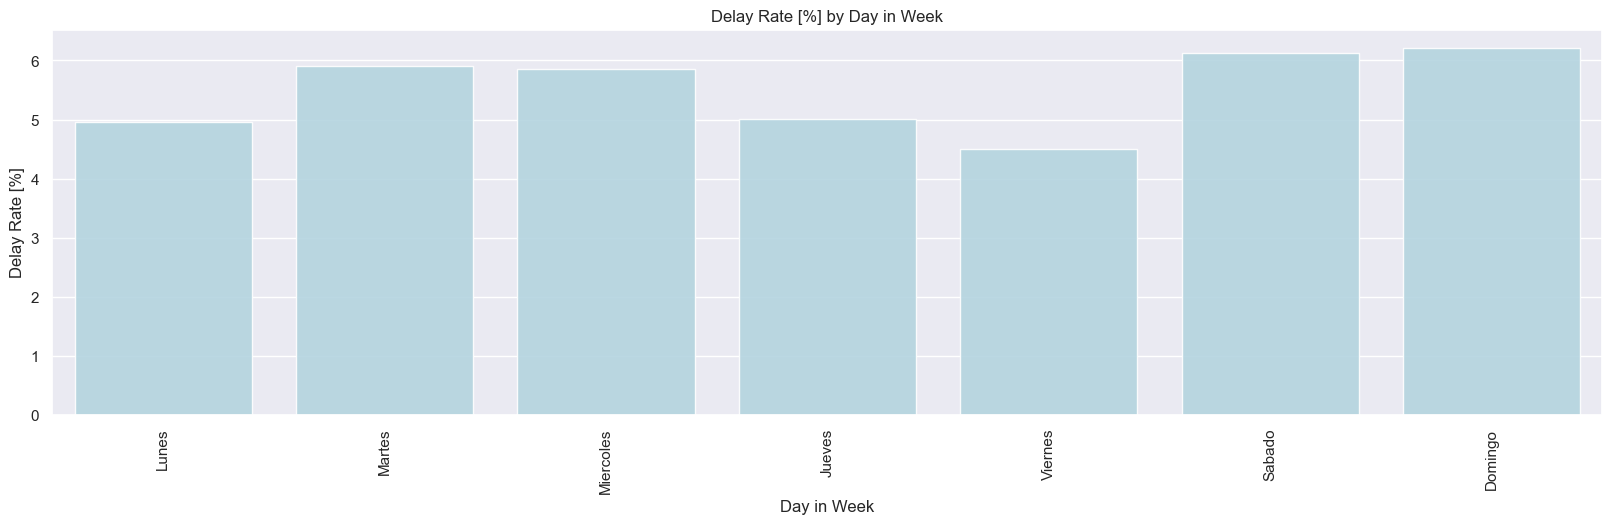

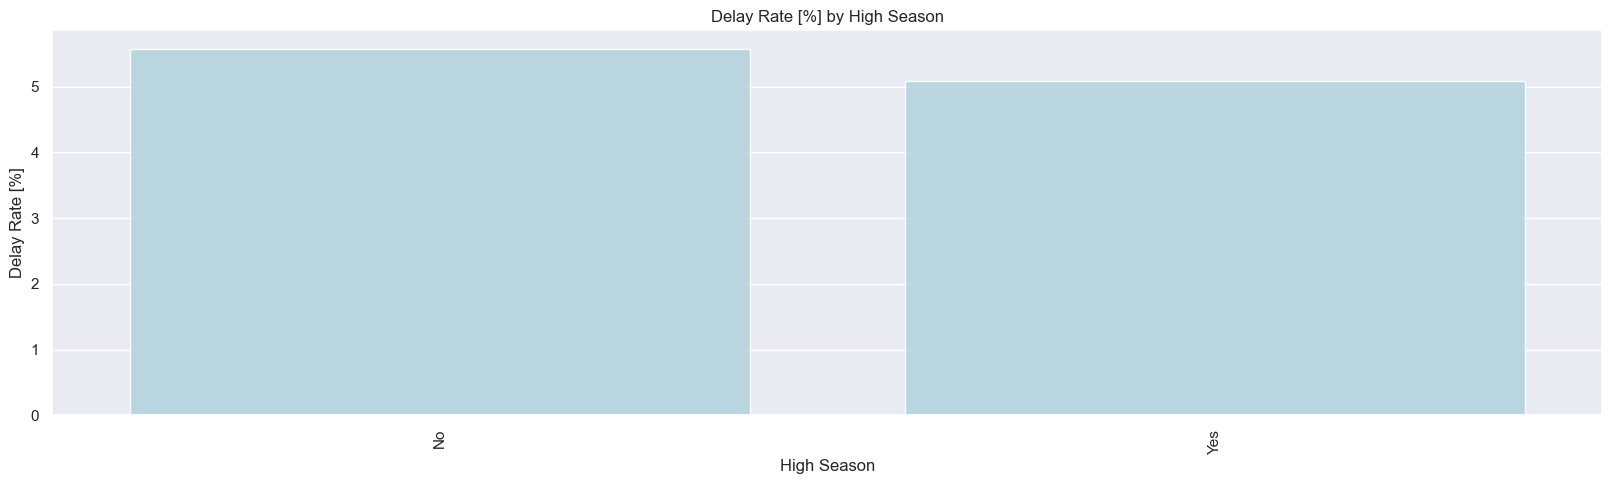

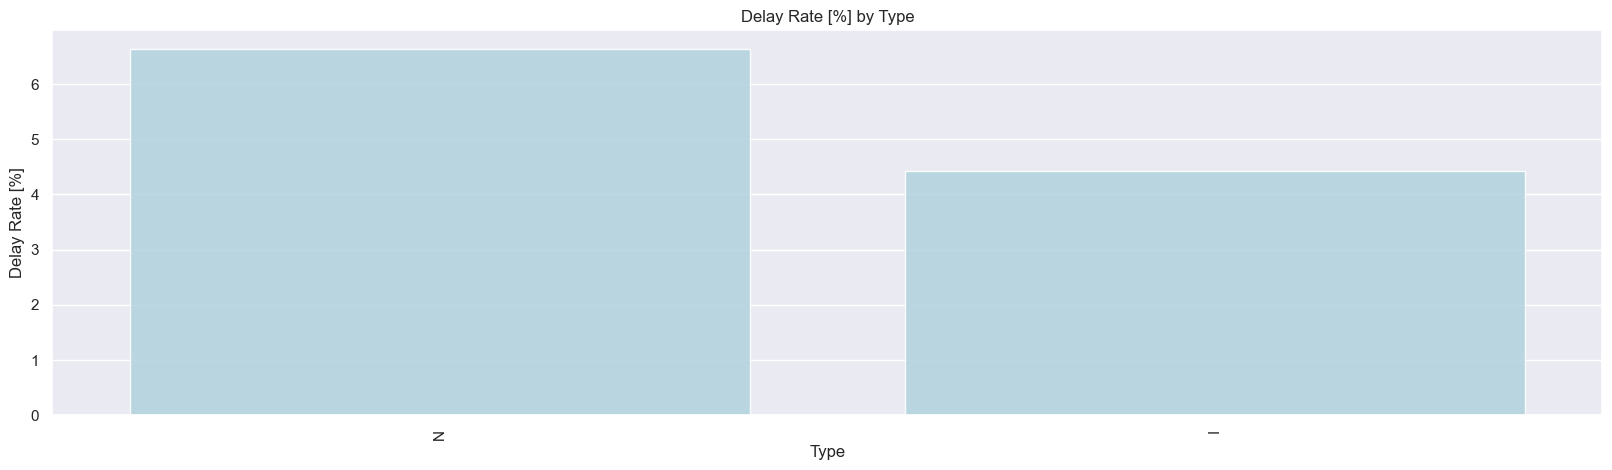

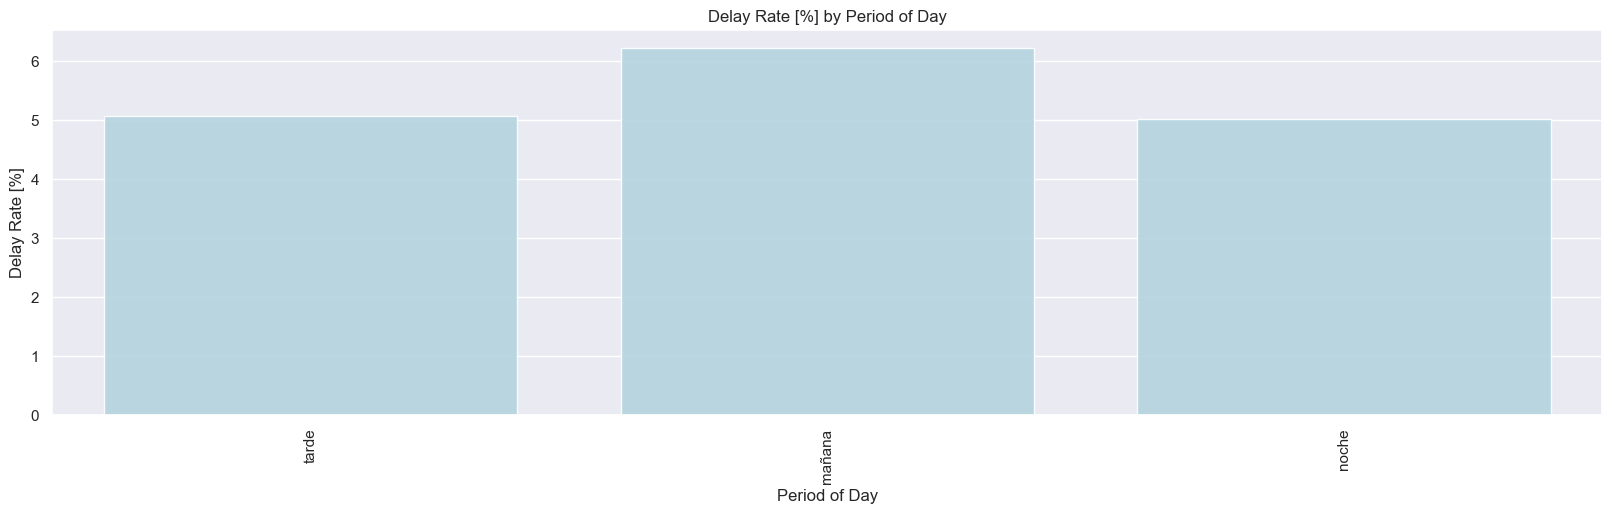

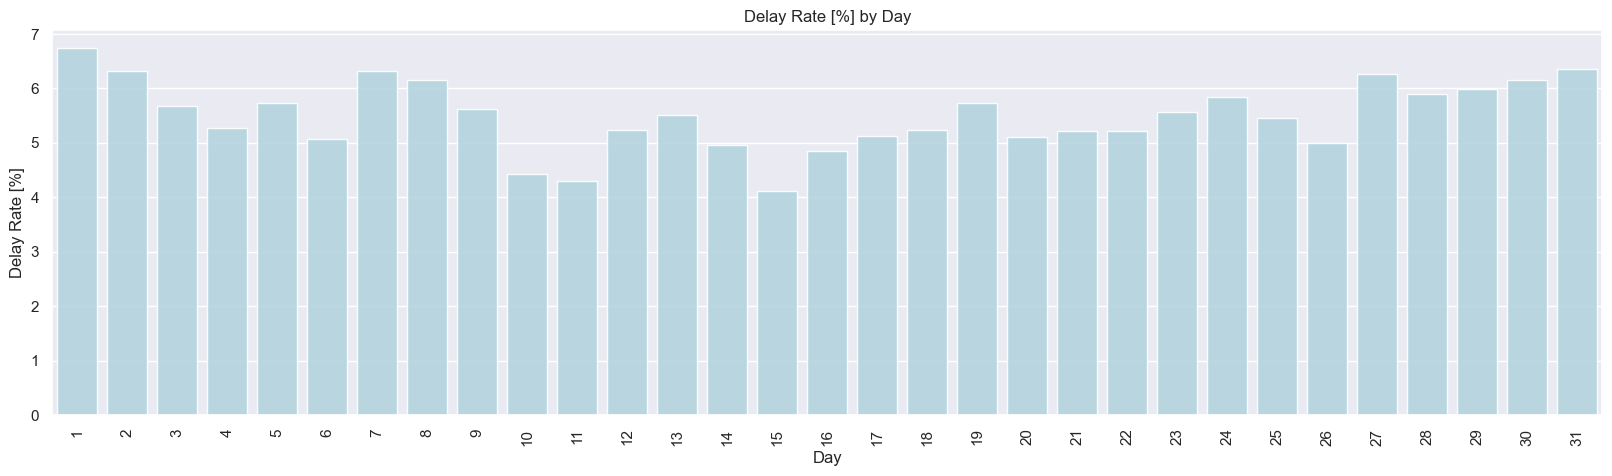

In [17]:
feat_name_map = {
    "SIGLADES": "Destination",
    "OPERA": "Airline",
    "MES": "Month",
    "DIANOM": "Day in Week",
    "high_season": "High Season",
    "TIPOVUELO": "Type",
    "period_day": "Period of Day",
    "DIA": "Day",    
}

for feat, name in feat_name_map.items():
    feat_rate = get_rate_from_column(data, feat)['Tasa (%)']
    feat_rate_values = data[feat].value_counts().index
    if feat == "DIANOM":
        order = [2, 5, 4, 1, 0, 6, 3]
        feat_rate = [feat_rate[idx] for idx in order]
        feat_rate_values = [feat_rate_values[idx] for idx in order]
    if feat == "high_season":
        feat_rate_values = ["Yes" if i == 1 else "No" for i in feat_rate_values]

    plot_flights_by_feature(x=feat_rate_values, y=feat_rate, feat_name=name, ylabel="Delay Rate [%]", size=(20, 5))

## 4. Training

### 4.a. Data Split (Training and Validation)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
training_data = shuffle(data[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']], random_state = 111)

In [21]:
training_data["delay"].value_counts()

0    55592
1    12614
Name: delay, dtype: int64

In [23]:
features = pd.concat([
    data["high_season"],
    pd.get_dummies(data["period_day"], prefix = 'period_day'),
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'),
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['SIGLADES'], prefix = 'SIGLADES'), 
    pd.get_dummies(data['MES'], prefix = 'MES'),
    pd.get_dummies(data['DIANOM'], prefix = 'DIANOM')
    ], 
    axis = 1
)

target = data['delay']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.33, random_state = 42)

In [25]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 110) | test shape: (22508, 110)


In [26]:
y_train.value_counts('%')*100

0    81.618452
1    18.381548
Name: delay, dtype: float64

In [27]:
y_test.value_counts('%')*100

0    81.277768
1    18.722232
Name: delay, dtype: float64

### 4.b. Model Selection

#### 4.b.i. XGBoost

In [30]:
import xgboost as xgb
from xgboost import plot_importance

def train_and_eval_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds = [1 if y_pred > 0.5 else 0 for y_pred in y_preds]
    print(confusion_matrix(y_test, y_preds))
    print(classification_report(y_test, y_preds))


In [31]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
train_and_eval_model(xgb_model, x_train, y_train, x_test, y_test)

[[18289     5]
 [ 4191    23]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.82      0.01      0.01      4214

    accuracy                           0.81     22508
   macro avg       0.82      0.50      0.45     22508
weighted avg       0.82      0.81      0.73     22508



#### 4.b.ii. Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression


reg_model = LogisticRegression()
train_and_eval_model(reg_model, x_train, y_train, x_test, y_test)

[[18153   141]
 [ 4028   186]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18294
           1       0.57      0.04      0.08      4214

    accuracy                           0.81     22508
   macro avg       0.69      0.52      0.49     22508
weighted avg       0.77      0.81      0.74     22508



## 5. Data Analysis: Third Sight

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x500 with 0 Axes>

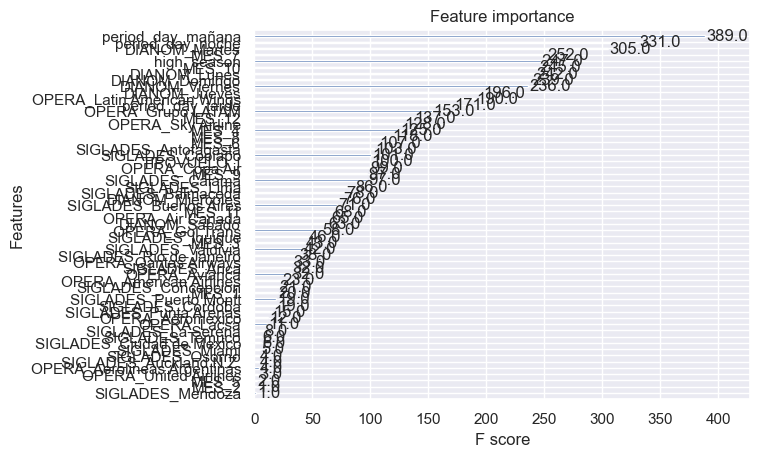

In [45]:
plt.figure(figsize = (10,5))
plot_importance(xgb_model)

In [46]:
def get_most_important_features(model, n_features):
    fimportance = model.get_booster().get_score(importance_type="gain") 
    fimportance = dict(sorted(fimportance.items(), key=lambda item: item[1])[-n_features::])

    top_10_features = list(fimportance.keys())
    return top_10_features

top_10_features = get_most_important_features(xgb_model, 10)

### Data Balance

In [47]:
n_y0 = len(y_train[y_train == 0])
n_y1 = len(y_train[y_train == 1])
scale = n_y0/n_y1
print(scale)

4.4402380952380955


## 6. Training with Improvement

### 6.a. Data Split

In [48]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features[top_10_features], target, test_size = 0.33, random_state = 42)

### 6.b. Model Selection

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [49]:
xgb_model_2 = xgb.XGBClassifier(random_state=1, learning_rate=0.01, scale_pos_weight = scale)
train_and_eval_model(xgb_model_2, x_train2, y_train2, x_test2, y_test2)

[[9393 8901]
 [1301 2913]]
              precision    recall  f1-score   support

           0       0.88      0.51      0.65     18294
           1       0.25      0.69      0.36      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.60      0.51     22508
weighted avg       0.76      0.55      0.59     22508



#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [50]:
xgb_model_3 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
train_and_eval_model(xgb_model_3, x_train2, y_train2, x_test2, y_test2)

[[18294     0]
 [ 4214     0]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.00      0.00      0.00      4214

    accuracy                           0.81     22508
   macro avg       0.41      0.50      0.45     22508
weighted avg       0.66      0.81      0.73     22508



#### 6.b.iii. Logistic Regression with Feature Importante and with Balance

In [51]:
reg_model_2 = LogisticRegression(class_weight={1: n_y0/len(y_train), 0: n_y1/len(y_train)})
train_and_eval_model(reg_model_2, x_train2, y_train2, x_test2, y_test2)

[[9393 8901]
 [1301 2913]]
              precision    recall  f1-score   support

           0       0.88      0.51      0.65     18294
           1       0.25      0.69      0.36      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.60      0.51     22508
weighted avg       0.76      0.55      0.59     22508



#### 6.b.iv. Logistic Regression with Feature Importante but without Balance

In [52]:
reg_model_3 = LogisticRegression()
train_and_eval_model(reg_model_3, x_train2, y_train2, x_test2, y_test2)

[[18210    84]
 [ 4118    96]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     18294
           1       0.53      0.02      0.04      4214

    accuracy                           0.81     22508
   macro avg       0.67      0.51      0.47     22508
weighted avg       0.76      0.81      0.74     22508



## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**